Formation OpenClassrooms DS-IML

**Projet 2**

Par **Marc Lefèvre**, <marc.lefevre@noos.fr>

# ANALYSE DE DONNÉES EXPLORATOIRE : Open Food Facts

## 2ème Partie

# Analyses Univariées & Nettoyage des données

Récupération des données et chargement des bibliothèques Python que nous allons utiliser.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from anova import *

In [2]:
df = pd.read_csv("Data/df_red1.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1443749 entries, 0 to 1443748
Data columns (total 29 columns):
code                                       1443749 non-null object
url                                        1443749 non-null object
countries_en                               1441453 non-null object
product_name                               1378190 non-null object
brands                                     795370 non-null object
allergens                                  168478 non-null object
nova_group                                 556104 non-null float64
additives_en                               371718 non-null object
additives_n                                640108 non-null float64
ingredients_from_palm_oil_n                640108 non-null float64
ingredients_that_may_be_from_palm_oil_n    640108 non-null float64
nutriscore_score                           582895 non-null float64
nutriscore_grade                           582895 non-null object
energy-kcal_100g    

## Analyse succinte des variables qualitatives *texte*

Nous avons observé que les champs textes de nos variables étaient soit composées d'un mot, soit d'expressions de plusieurs mots, soit de plusieurs mots ou expressions séparés par des virgules. Nous allons nous contenter, pour l'instant, d'observer les distributions du nombre de **mots uniques** dans ces variables.<br><br>Les mots et expressions auront été au préalable, grâce à la fonction ci-dessous :<br>- Passés en minuscules<br>- Débarassés de préfixes tels **"en:"**, **"fr:"** ou **"es"**:"<br>- Regroupés dans des suites de mots uniques séparés entre eux par des *espaces*.

In [3]:
# Fonction de mise en forme    
def conv_suite_mots(s):
    
    # on ne touche pas aux valeurs nulles
    if type(s) != float :
  
        liste = s.lower().split(", ")
        new = []
        
        for w in liste :
            
            if w.startswith("en:"):
                w = w[3:]
            elif w.startswith("fr:"):
                w = w[3:]
            elif w.startswith("es:"):
                w = w[3:]
            new.append(w)
        
        new = list(set(new))
        return " ".join(new)

Application du traitement

In [4]:
colonnes = df.columns[2:8].tolist()
colonnes.remove("nova_group")

for col in colonnes :
    df[col] = df[col].map(conv_suite_mots)

Boucle de création des histogrammes

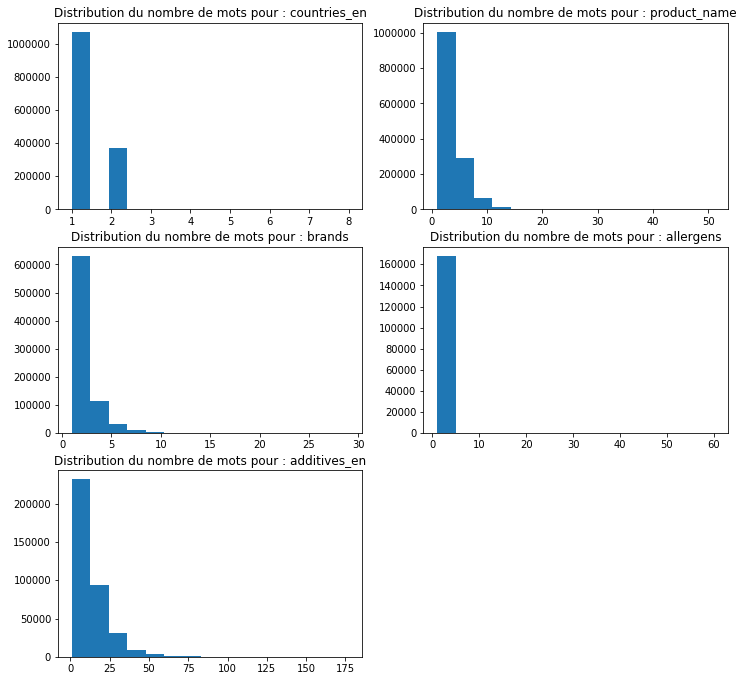

In [5]:
plt.figure(figsize=(12,24))
i=1

for col in colonnes :   
    
    mots = df[df[col].notnull()][col].str.split(" ").apply(lambda x: len(x))
    plt.subplot(6,2,i)
    plt.hist(mots, bins=15)
    plt.title(f'Distribution du nombre de mots pour : {col}')
    i+=1

plt.show()

On peut remarquer qu'il existe parfois d'importantes disparités, au sein d'une même variable, dans la façon dont cette variable a été renseignées. C'est juste que certains produits ont été plus détaillés ou contiennent beaucoup d'additifs ou d'allergènes.

### Autre variable qualitative : **Nova Group**

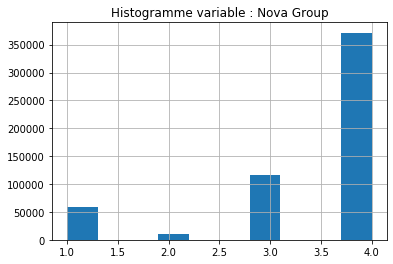

In [6]:
df.nova_group.hist()
plt.title("Histogramme variable : Nova Group")
plt.show()

La variable **Nova Group**, qui est un *indice de transformation des aliments* (avec des valeurs allant de 1 à 4 du moins au plus transformé), semble correctemment renseignée.<br>Nous reviendrons plus tard sur elle en l'analysant avec le **Nutriscore_grade**.<br>En attendant, il est intéressant de voir que pour environ les deux tiers des produits renseignés, l'indice est maximum...

## Variables quantitatives discontinues

Observons nos quatre variables suivantes.

In [7]:
df[df.columns[8:11].tolist()].describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n
count,640108.000000,640108.000000,640108.000000
mean,2.010467,0.020811,0.069804
std,2.846657,0.144587,0.302400
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,3.000000,0.000000,0.000000
max,49.000000,3.000000,6.000000


Si les deux autres ne semblent pas montrer d'irrégularités, avec la variable **additives_n** la différence entre sa valeur maximum et son **Q3** nous laisse fortement penser qu'elle contient des **outliers**. C'est aussi frappant visuellement.

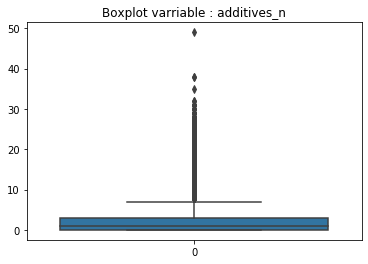

In [8]:
sns.boxplot(data=df["additives_n"])
plt.title("Boxplot varriable : additives_n")
plt.show()

Nous décidon d'éliminer les observations, que nous considérons comme aberrantes, dont les valeurs pour cette variable seront **supérieures à 30**.

In [9]:
df = df[(df.additives_n.isnull()) | (df.additives_n <= 30)]

## Nutriscore :  score & grade

La valeur numérique du **Nutriscore**, c'est à dire la variable **"nutriscore_score"**, dont on peut trouver le détail des calculs et les modalités ici :<br>https://www.santepubliquefrance.fr/media/files/02-determinants-de-sante/nutrition-et-activite-physique/nutri-score/qr-scientifique-technique-en<br>est une valeur numérique comprise entre **-15** et **40**.

In [11]:
df[df.columns[11:12]].describe()

,nutriscore_score
count,582888.000000
mean,9.173872
std,8.914258
min,-15.000000
25%,1.000000
50%,10.000000
75%,16.000000
max,40.000000


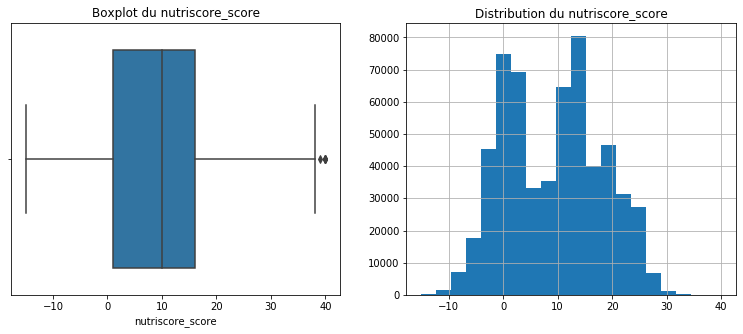

In [12]:
plt.figure(figsize = (13,5))

plt.subplot(1,2,1)
plt.title("Boxplot du nutriscore_score")
sns.boxplot(df["nutriscore_score"])

plt.subplot(1,2,2)
plt.title("Distribution du nutriscore_score")
df.nutriscore_score.hist(bins=20)

plt.show()

Si ce n'est sa distribution multi-modale, on ne remarque rien de particulier avec cette variable qui ne semble pas appeler de correction.

Quant au Classement Nutriscore, une appréciation sous forme de lettre **A, B, C, D** ou **E**, il est donné par la variable qualitative **"nutriscore_grade"**.

La relation entre le **nutriscoe_score** et le **nutriscore_grade** est expliquée dans le tableau suivant :
<img src="calc_nutri.png">

In [13]:
df.nutriscore_grade.value_counts()

d    180667
c    122401
e    110512
a     94450
b     74858
Name: nutriscore_grade, dtype: int64

Toutes les valeurs renseignées correspondent bien à ce qui est attendu. On peut même observer visuellement la répartition des valeurs dans un diagramme circulaire.

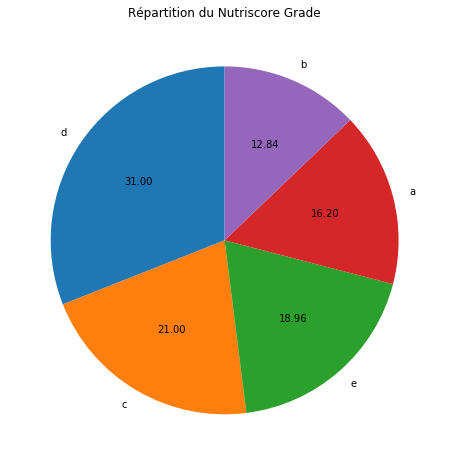

In [14]:
plt.figure(figsize = (8,8))
plt.title('Répartition du Nutriscore Grade')
plt.pie(df["nutriscore_grade"].value_counts(), autopct='%.2f', 
        labels = df["nutriscore_grade"].value_counts().index, startangle=90)
plt.show()

En prenant un peu d'avance et sans attendre la partie de cette étude consacrée aux analyses multivariées du dataset, nous allons regarder la relation entre les deux **nutriscores**.

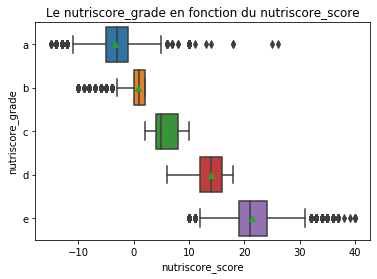

In [15]:
plt.title("Le nutriscore_grade en fonction du nutriscore_score")
sns.boxplot(df["nutriscore_score"], df["nutriscore_grade"].sort_values(), showmeans=True)
plt.show()

Et nous avons bien fait...<br>En effet, au regard du diagramme, et en tenant compte des règles d'attribution du **nutriscore_grade** en fonction du **nutriscore_score**, il semble y avoir un certain nombre d'erreurs avec sa population de classe **"a"**.<br>Cellee-ci, d'après ces règles, ne peut avoir un nutriscore supérieur à **-1**.<br>Or :

In [16]:
df[df.nutriscore_grade == "a"]["nutriscore_score"].describe()

count    94450.000000
mean        -3.396379
std          2.307783
min        -15.000000
25%         -5.000000
50%         -3.000000
75%         -1.000000
max         26.000000
Name: nutriscore_score, dtype: float64

In [17]:
len(df[(df.nutriscore_score > -1) & (df.nutriscore_grade == "a")])

2282

Nous voyons qu'un groupe de **2282** individus de cette population (dont le **nutriscore_score** se situe dans l'intervalle **Q3** - **max**) se trouve dans cette situation d'incohérence.

Comme nous n'avons pas le moyen de savoir d'où vient cette erreur, nous allons au moins essayer de rendre la variable plus cohérente en ventilant (un peu arbitrairement) ses valeurs erronées (de classe **a** avec des **nutriscore_score** supérieurs à **"-1"**) dans les autres catégories **b**, **c**, **d** et **e**.

In [18]:
df.loc[(df["nutriscore_grade"] == "a") & (df["nutriscore_score"] > -1) & (df["nutriscore_score"] <= 2), 
       "nutriscore_grade"] = "b"
df.loc[(df["nutriscore_grade"] == "a") & (df["nutriscore_score"] > 2) & (df["nutriscore_score"] <= 10), 
       "nutriscore_grade"] = "c"
df.loc[(df["nutriscore_grade"] == "a") & (df["nutriscore_score"] > 10) & (df["nutriscore_score"] <= 18), 
       "nutriscore_grade"] = "d"
df.loc[(df["nutriscore_grade"] == "a") & (df["nutriscore_score"] > 18), 
       "nutriscore_grade"] = "e"

Notre **nutriscore_grade** a maintenant meilleure allure !

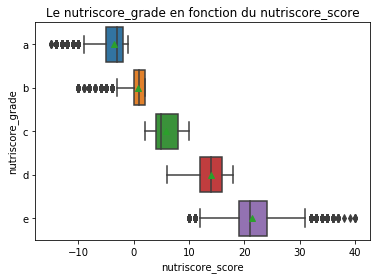

In [20]:
plt.title("Le nutriscore_grade en fonction du nutriscore_score")
sns.boxplot(df["nutriscore_score"], df["nutriscore_grade"].sort_values(), showmeans=True)
plt.show()

### **ANOVA** des nutriscores

On utilise la fonction **anova** importée du module **anova.py** (voir cellule ci-dessous).<br>Elle affiche la **table anova** de cette analyse (avec en plus le **SCT** et **R2**), nous fournissant ainsi les indicateurs nous permettant de statuer réellement sur une éventuelle corrélation linéaire entre nos deux variables, et d'autres couples de variables quantitatives et qualitatives en général.

In [21]:
anova(df, "nutriscore_grade", "nutriscore_score")

TABLE ANOVA nutriscore_grade en fonction nutriscore_score

                df        sum_sq       mean_sq             F  PR(>F)
Q(vqual)       4.0  4.221583e+07  1.055396e+07  1.499432e+06     0.0
Residual  582883.0  4.102700e+06  7.038635e+00           NaN     NaN
SCT                         4.631853e+07
R2 = 0.9114242011779303


Comme on s'y attendait, l'hypothèse nulle d'indépendance des deux variables est clairement rejetée. Néanmoins, la corrélation aurait pu être encore plus marquée si le système d'attribution du **nutriscore_grade** pour les **boissons** ne provoquait pas en chevauchement de valeurs.

## Variables quantitatives continues

### Les valeurs énergétiques

In [23]:
df[df.columns[13:15]].describe()

,energy-kcal_100g,energy_100g
count,1.094588e+06,1.163787e+06
mean,7.944650e+06,5.727473e+36
std,8.309733e+09,6.178739e+39
min,0.000000e+00,0.000000e+00
25%,1.010000e+02,4.180000e+02
50%,2.640000e+02,1.092000e+03
75%,4.000000e+02,1.674000e+03
max,8.693855e+12,6.665559e+42


Avec ces deux variables représentants l'apports énergétique des produits concernés, la première en **kcal**, la seconde en **kj** (on rappelle que **1 kcal = 4,1868 kJ**), on se rend bien compte que nous sommes en présence d'**outliers** assez extrêmes. L'ordre de grandeur de l'énergie, en kcal , apportée par 100g de nourriture, est la centaine *10e2*. En kj, on peut attendre le millier, **10e3**.<br>Avec ici des énergies de l'ordre de **10e12** (presque l'énergie dégagée par une bombe atomique) et **10e42** (10e30 bombes atomiques), nous sommes en présence d'outliers, de "pics", absurdement grands.<br>On remarquera au passage que valeurs moyennes et écarts-types sont particulièrement sensibles à ce type d'outliers extrêmes, contrairement à la valeur médianne et autres quantiles.

Nous fixons deux seuils. le premier de **1500** pour **"energy-kcal_100g"** et le second de **6200** pour **"energy_100g"** au dessus desquels nous décidons d"effacer les observations.

In [24]:
df = df[(df["energy-kcal_100g"].isnull()) | (df["energy-kcal_100g"] <= 1500)]
df = df[(df["energy_100g"].isnull()) | (df["energy_100g"] <= 6200)]

### Données nutritionnelles

In [25]:
df[df.columns[15:]].describe()

,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g
count,1.154305e+06,1.107510e+06,263902.000000,267888.000000,1.153760e+06,1.132704e+06,445640.000000,1.155552e+06,1.134185e+06,1.134179e+06,211762.000000,219312.000000,268485.000000,263848.000000
mean,1.381774e+01,1.227980e+08,0.046625,0.046948,2.850017e+01,1.386366e+01,2.940072,8.447355e+00,2.020402e+00,8.082414e-01,0.003606,0.024592,0.170965,0.006437
std,1.716359e+02,1.292305e+11,1.062264,1.459132,2.856277e+01,2.008663e+01,5.000099,1.274801e+01,1.410919e+02,5.643743e+01,0.507448,0.754796,7.849169,0.266175
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,-1.000000e+00,-20.000000,-5.000000e+02,0.000000e+00,0.000000e+00,-0.000340,0.000000,0.000000,-0.000260
25%,6.000000e-01,1.000000e-01,0.000000,0.000000,3.570000e+00,7.000000e-01,0.000000,1.200000e+00,6.000000e-02,2.400000e-02,0.000000,0.000000,0.000000,0.000000
50%,6.900000e+00,1.900000e+00,0.000000,0.000000,1.570000e+01,3.900000e+00,1.560000,5.800000e+00,5.350000e-01,2.140000e-01,0.000000,0.000000,0.036000,0.001000
75%,2.142857e+01,7.220000e+00,0.000000,0.022000,5.357000e+01,2.000000e+01,3.600000,1.200000e+01,1.353820e+00,5.415280e-01,0.000107,0.004000,0.109000,0.002400
max,1.536795e+05,1.360000e+14,369.000000,300.000000,2.916670e+03,1.350000e+03,439.000000,8.466000e+03,1.050000e+05,4.200000e+04,126.000000,100.000000,3400.000000,50.000000


Toutes ces données représentent une masse de *quelque chose* (graisse, sucre, etc.) pour 100g du produit concerné.<br>Nous avons donc deux **règles métier** implicites pour traiter une grande partie des **outliers** de celles-ci :<br>Nous pouvons nous séparer des observations dont les valeurs sont soit **négatives**, soit **supérieures ou égales à 100**.

In [26]:
for col in df.columns[15:]:
    df = df[(df[col].isnull()) | (df[col] >= 0)]
    df = df[(df[col].isnull()) | (df[col] < 100)]

On peut maintenant observer nos variables après cette premier nettoyage.

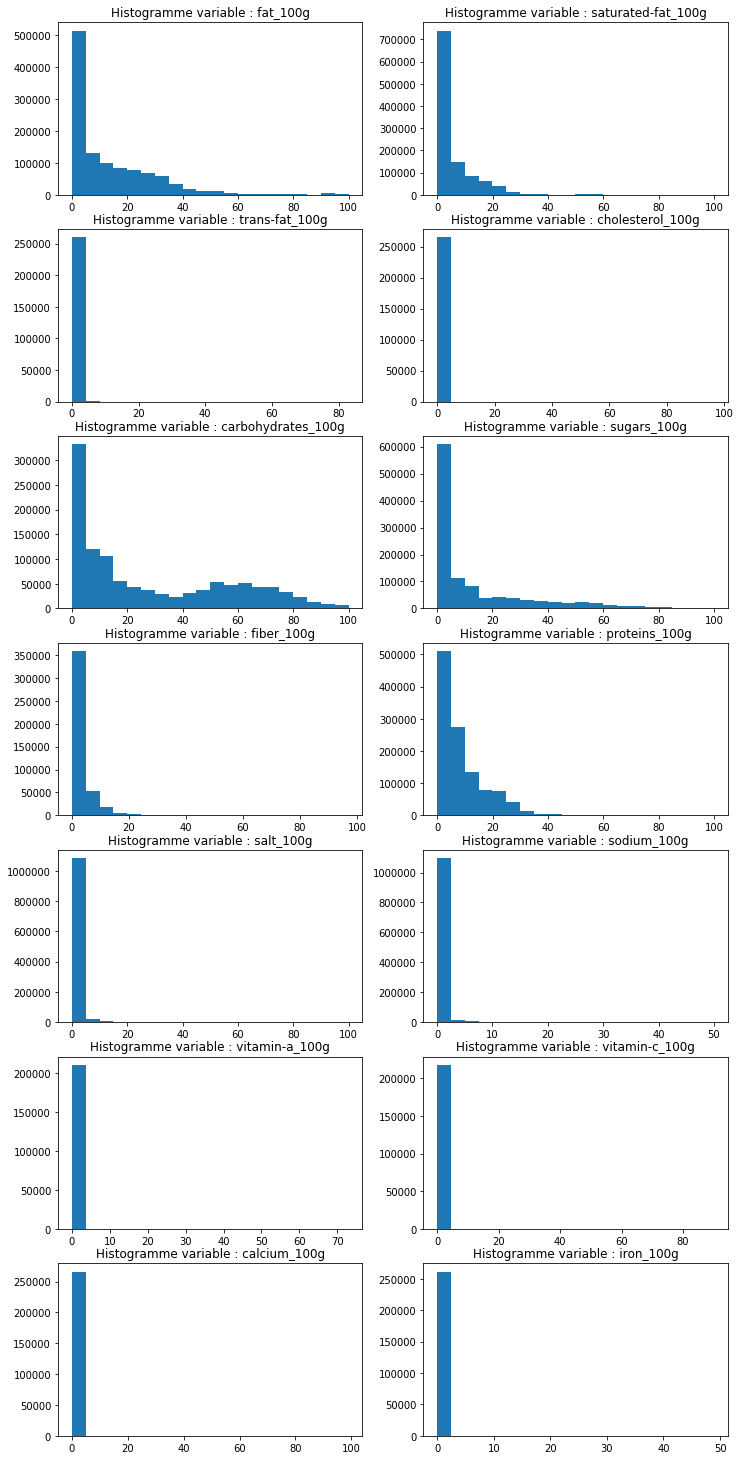

In [27]:
plt.figure(figsize=(12,26))
i=1
for col in df.columns[15:]:    
    plt.subplot(7,2,i)
    plt.hist(df[col], bins=20)
    plt.title(f'Histogramme variable : {col}')
    i+=1
plt.show()

## Note sur les valeurs manquantes

- Nous tenterons plus tard de compléter autant que possible les valeurs manquantes de la variable **nutriscore_grade** par le moyen d'un modèle.
- Pour ce qui est des autres variables, et pour le moment, nous comptons préserver et *faire avec* les valeurs nulles. Particulièrement pour ce qui est de variables quantitatives, nous n'avons pas d'élément nous permettant de décider d'une valeur à leur attribuer, nous ne pouvont pas non plus les éliminer, car cela réduirait trop le dataset.

Avant de passer à la suite, nous sauvegardons notre dataset sous le nom de **df_red2.csv**.

In [28]:
df.to_csv("Data/df_red2.csv", index=False)

Fin de la **2ème partie**.